## Schema object coocurrence

Take all of the object-with-predicates, count how many times each object co-occurs with objects in the predicates


In [ ]:
object_object_coocurrence = defaultdict(lambda: defaultdict(lambda: 0))
object_predicate_coocurrence = defaultdict(lambda: defaultdict(lambda: 0))
all_predicates = set()

for game_objects in stats_df.objects_with_predicates:
    for object_with_predicates in game_objects:
        first_object = object_with_predicates['object']
        if 'predicates' in object_with_predicates:
            for predicate_desc in object_with_predicates['predicates']:
                second_object = None
                if 'object' in predicate_desc:
                    second_object = predicate_desc['object']
                    object_object_coocurrence[first_object][second_object] += 1
                    object_object_coocurrence[second_object][first_object] += 1

                if 'predicate' in predicate_desc:
                    all_predicates.add(predicate)
                    predicate = predicate_desc['predicate']
                    object_predicate_coocurrence[first_object][predicate] += 1
                    if second_object:
                        object_predicate_coocurrence[second_object][predicate] += 1

individual_object_ocurrence = {key: sum(object_object_coocurrence[key].values()) for key in object_object_coocurrence}
sorted_objects = [item[0] for item in sorted(individual_object_ocurrence.items(), key=lambda item: item[1], reverse=True)]
n_object_types = len(sorted_objects)
schema_object_coocurrence = np.zeros((n_object_types, n_object_types))
for i, i_obj in enumerate(sorted_objects):
    for j, j_obj in enumerate(sorted_objects):
        schema_object_coocurrence[i, j] = object_object_coocurrence[i_obj][j_obj]

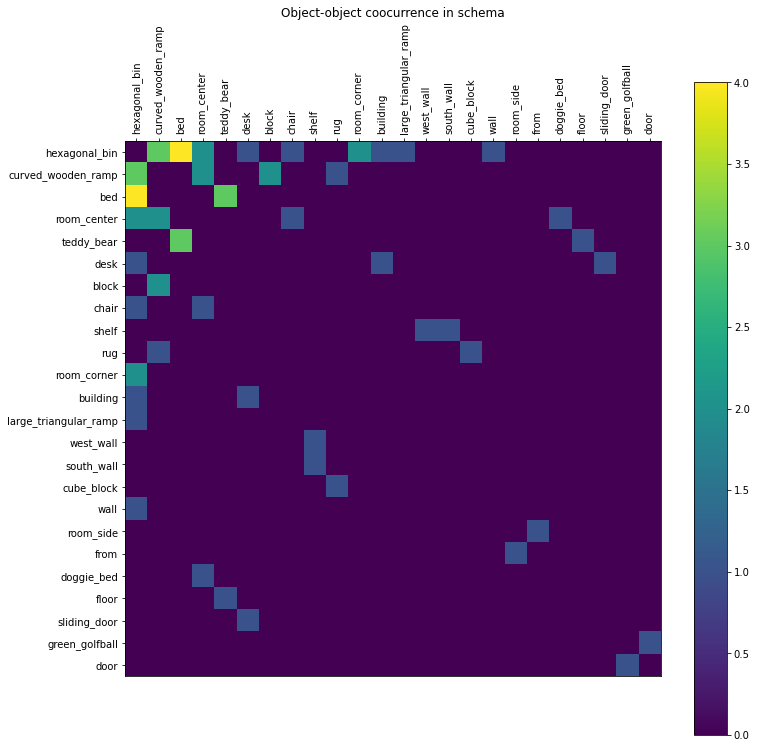

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(schema_object_coocurrence)
plt.xticks(np.arange(n_object_types), sorted_objects, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_object_types), sorted_objects)
plt.colorbar()
plt.title('Object-object coocurrence in schema')
plt.show()

In [ ]:
individual_object_predicate_ocurrence = {key: sum(object_predicate_coocurrence[key].values()) for key in object_predicate_coocurrence}
sorted_predicate_objects = [item[0] for item in sorted(individual_object_predicate_ocurrence.items(), key=lambda item: item[1], reverse=True)]
n_predicate_object_types = len(sorted_predicate_objects)

individual_predicate_counts = {predicate: sum([object_predicate_coocurrence[obj][predicate] for obj in object_predicate_coocurrence]) for predicate in all_predicates}
sorted_predicates = [item[0] for item in sorted(individual_predicate_counts.items(), key=lambda item: item[1], reverse=True)]
n_predicate_types = len(all_predicates)

schema_object_predicate_coocurrence = np.zeros((n_predicate_object_types, n_predicate_types))
for i, obj in enumerate(sorted_predicate_objects):
    for j, pred in enumerate(sorted_predicates):
        schema_object_predicate_coocurrence[i, j] = object_predicate_coocurrence[obj][pred]

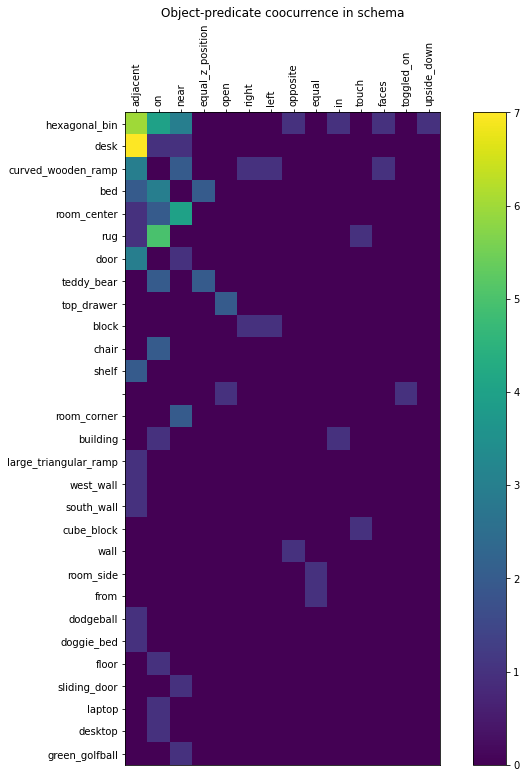

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(schema_object_predicate_coocurrence)
plt.xticks(np.arange(n_predicate_types), sorted_predicates, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_predicate_object_types), sorted_predicate_objects)
plt.colorbar()
plt.title('Object-predicate coocurrence in schema')
plt.show()

## Total nodes by type

<AxesSubplot:title={'center':'AST Nodes'}, ylabel='Frequency'>

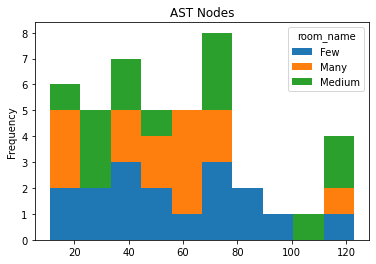

In [ ]:
stats_df.pivot(columns='room_name').ast_nodes.plot(kind='hist', stacked=True, title='AST Nodes')

## Max Depth by type

<AxesSubplot:title={'center':'Max Depth'}, ylabel='Frequency'>

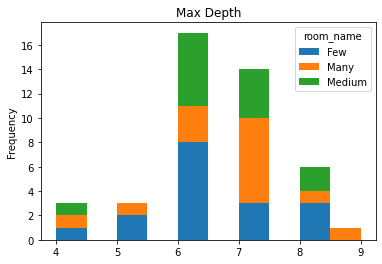

In [ ]:
stats_df.pivot(columns='room_name').max_depth.plot(kind='hist', stacked=True, title='Max Depth')

## Number of preferences histogram by room type

<AxesSubplot:title={'center':'Number of Preferences'}, ylabel='Frequency'>

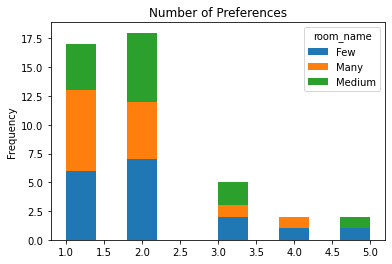

In [ ]:
stats_df.pivot(columns='room_name').num_preferences.plot(kind='hist', stacked=True, title='Number of Preferences')


## Parsing the types/counts of objects quantified

In [ ]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
coocurrence_results = defaultdict(lambda: defaultdict(lambda: 0))


for i, (object_types, room_name) in stats_df.loc[:, ('object_types_quantified', 'room_name')].iterrows():
    object_types = json.loads(object_types.replace("'", '"'))
    for obj_type, count in object_types.items():
        results[obj_type][room_name]['games'] += 1
        results[obj_type][room_name]['references'] += count

    types = list(object_types.keys())
    for first_type, second_type in combinations(types, 2):
        coocurrence_results[first_type][second_type] += 1
        coocurrence_results[second_type][first_type] += 1

result_rows = []
for obj_type, obj_results in results.items():
    for room_name, room_results in obj_results.items():
        result_rows.append((obj_type, room_name, room_results['games'], room_results['references']))

object_counts_df = pd.DataFrame.from_records(result_rows, 
    columns=('object_type', 'room_name', 'games', 'references'))


all_object_types = object_counts_df.object_type.unique()
n_object_types = len(all_object_types)
object_type_cocurrence = np.zeros((n_object_types, n_object_types), dtype=np.int)
object_type_to_id = {obj_type:i for i, obj_type in enumerate(all_object_types)}

for first_obj_type, first_obj_results in coocurrence_results.items():
    for second_obj_type, count in first_obj_results.items():
        object_type_cocurrence[object_type_to_id[first_obj_type]][object_type_to_id[second_obj_type]] = count


object_room_counts = object_counts_df.groupby('object_type').room_name.count()

object_counts_df.head()

,object_type,room_name,games,references
0,hexagonal_bin,Medium,8,16
1,hexagonal_bin,Few,12,19
2,hexagonal_bin,Many,5,9
3,triangular_ramp,Medium,1,2
4,triangular_ramp,Many,1,2


# Readme
* `object_type`: the type of the object
* `src_file`: as above, the name of the source file (room survet or interactive) by the number of items
* `games`: how many games (for this room) refer to this object at least once, as part of quantifiers (`exists`/`forall`).
* `references`: how many total references appear to this object type in quantifiers in games of this type. 
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.

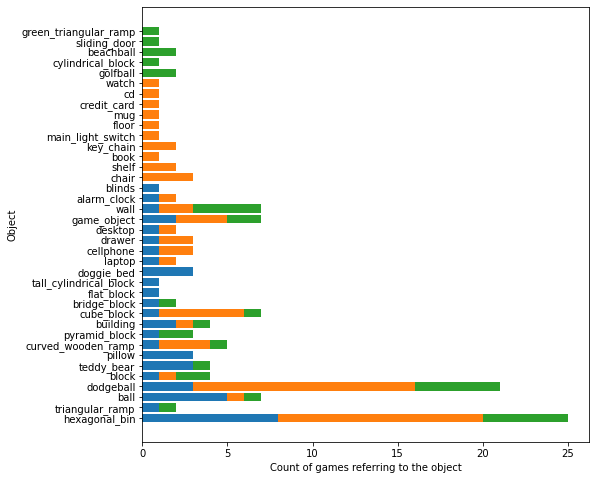

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'games')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.games, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of games referring to the object')
ax.set_ylabel('Object')
plt.show()

## Would the above be more interesting as...?**
* Fraction of the games that referred to the item?
    * ... from the games that could (that is, from the ones that had the type of object in the room)
* Counting the total quantifications, instead of only the number of games that refer to a particular type?
    * Graph with the total quantifications below:
* Makes some sort of aggregation? Balls, blocks, etc.?
* Separated between setup and preferences?
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.


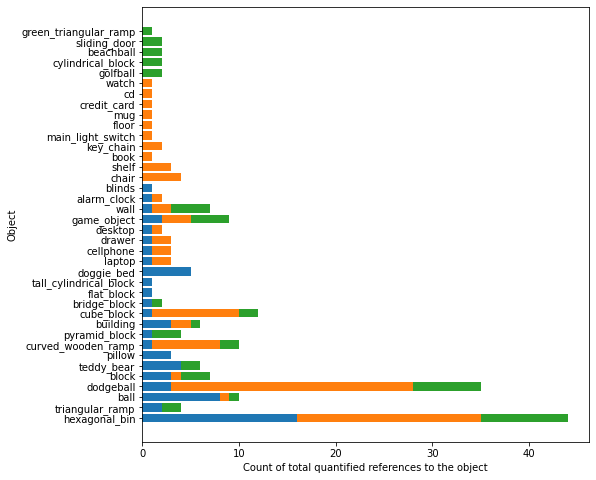

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'references')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.references, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of total quantified references to the object')
ax.set_ylabel('Object')
plt.show()

## Co-ocurrence between different objects (within a game)

* Would this be more interesting as within a particular quantification (exists/forall)? 
* Or split by setup and preferences?

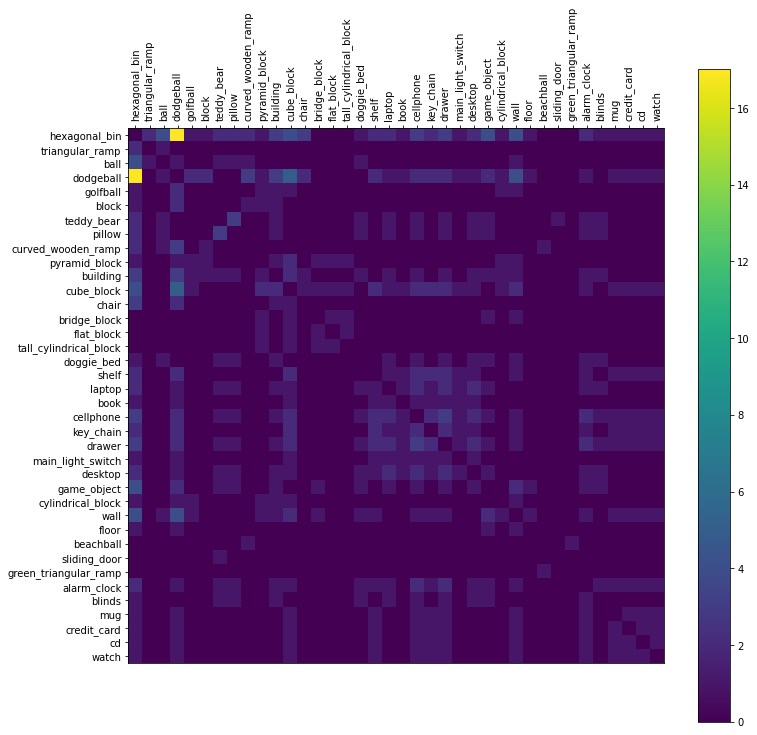

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(object_type_cocurrence)
plt.xticks(np.arange(n_object_types), all_object_types, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_object_types), all_object_types)
plt.colorbar()
plt.show()

## Same as above, but sorted by count

Loses some of the block structure, but gains a better sense of the important and recurring objects

In [ ]:
ocurrence_counts = object_type_cocurrence.sum(axis=0)
desc_order = np.argsort(ocurrence_counts)[::-1]
sorted_object_type_cocurrence = np.zeros_like(object_type_cocurrence)

for i in range(sorted_object_type_cocurrence.shape[0]):
    sorted_object_type_cocurrence[i, :] = object_type_cocurrence[desc_order[i], desc_order]

sorted_object_types = all_object_types[desc_order]

temp = np.copy(object_type_cocurrence).astype(np.float)
for i, i_obj_type in enumerate(sorted_object_types):
    for j, j_obj_type in enumerate(sorted_object_types):
        temp[i,j] /= min(object_room_counts[i_obj_type], object_room_counts[j_obj_type])

normed_sorted_object_type_cocurrence = np.zeros_like(temp)
normed_desc_order = np.argsort(temp.sum(axis=0))[::-1]
for i in range(normed_sorted_object_type_cocurrence.shape[0]):
    normed_sorted_object_type_cocurrence[i, :] = temp[normed_desc_order[i], normed_desc_order]

normed_sorted_object_types = all_object_types[normed_desc_order]

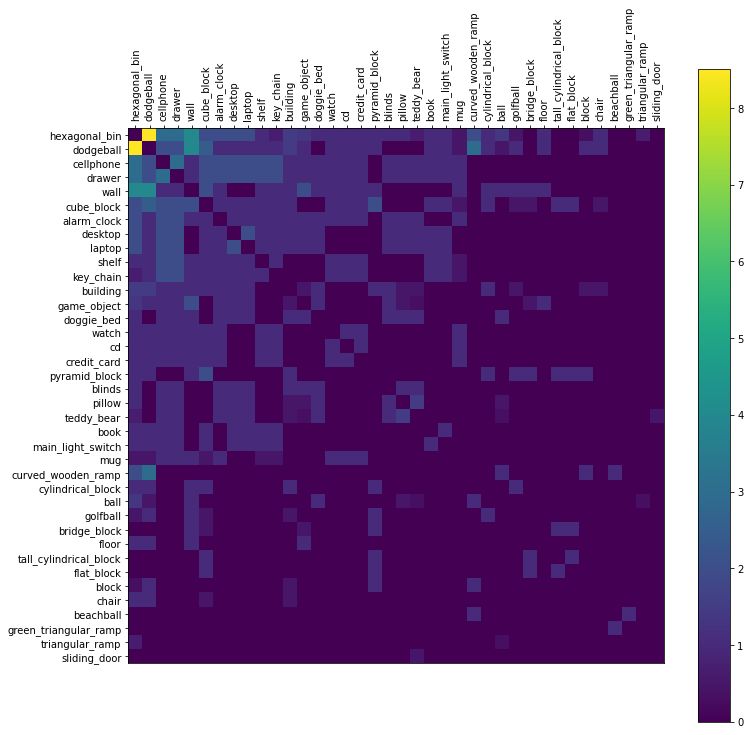

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(normed_sorted_object_type_cocurrence)
plt.xticks(np.arange(n_object_types), normed_sorted_object_types, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_object_types), normed_sorted_object_types)
plt.colorbar()
plt.show()

## Correlation table and p-values

In [ ]:
NUMERIC_COLUMNS = [
    'src', 'average_length_of_then', 'average_setup_objects_quantified', 'average_preference_objects_quantified',
    'terminal_exists', 'is_throwing', 'is_construction', 'difficulty', 'first_time_points'
]

numeric_df = stats_df[NUMERIC_COLUMNS]
numeric_df.loc[:, 'terminal_exists'] = numeric_df.terminal_exists.astype(np.float)

arr = numeric_df.to_numpy(dtype=np.float)
nan_masked_arr = np.ma.masked_invalid(arr)
corr = np.ma.corrcoef(nan_masked_arr, rowvar=False)
corr_df = pd.DataFrame(corr, columns=numeric_df.columns, index=numeric_df.columns)
corr_df

/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,src,average_length_of_then,average_setup_objects_quantified,average_preference_objects_quantified,terminal_exists,is_throwing,is_construction,difficulty,first_time_points
src,1.000000,-0.040132,-0.228823,-0.067254,0.004964,-0.001615,0.055249,0.026976,0.030303
average_length_of_then,-0.040132,1.000000,0.115405,0.305243,-0.088304,-0.113199,0.113199,0.105919,-0.093442
average_setup_objects_quantified,-0.228823,0.115405,1.000000,0.198426,-0.005383,-0.088931,-0.150754,0.224107,-0.113244
average_preference_objects_quantified,-0.067254,0.305243,0.198426,1.000000,-0.213596,0.316664,-0.325135,-0.038086,-0.050620
terminal_exists,0.004964,-0.088304,-0.005383,-0.213596,1.000000,0.298976,-0.172691,0.010456,0.220149
is_throwing,-0.001615,-0.113199,-0.088931,0.316664,0.298976,1.000000,-0.704100,-0.141785,0.076799
is_construction,0.055249,0.113199,-0.150754,-0.325135,-0.172691,-0.704100,1.000000,0.141785,-0.086809
difficulty,0.026976,0.105919,0.224107,-0.038086,0.010456,-0.141785,0.141785,1.000000,0.097486
first_time_points,0.030303,-0.093442,-0.113244,-0.050620,0.220149,0.076799,-0.086809,0.097486,1.000000


In [ ]:
n_rows = nan_masked_arr.shape[1]
n = np.zeros((n_rows, n_rows), dtype=np.int)

for i in range(n_rows):
    for j in range(i, n_rows):
        n[i, j] = n[j, i] = np.invert(nan_masked_arr.mask[:,[i, j]].any(axis=1)).sum()

n

t_stat = corr.data * np.sqrt(n - 2) / np.sqrt(1 - (corr.data ** 2))
t_stat[np.diag_indices(t_stat.shape[0])] = 0
p_values = stats.t(n - 2).sf(np.abs(t_stat)) * 2

<ipython-input-44-4b5b89404fdf>:10: RuntimeWarning: divide by zero encountered in true_divide
  t_stat = corr.data * np.sqrt(n - 2) / np.sqrt(1 - (corr.data ** 2))


### P-values

In [ ]:
output_p_values = []
for i, row in enumerate(p_values):
    output_p_values.append([corr_df.columns[i]] + [f'{p:1.4f}{"*" if p < 0.05 else ""}{"*" if p < 0.01 else ""}{"*" if p < 0.001 else ""}' for p in row])

headers = [""] + corr_df.columns
tabulate(output_p_values, headers, tablefmt='html')

,src,average_length_of_then,average_setup_objects_quantified,average_preference_objects_quantified,terminal_exists,is_throwing,is_construction,difficulty,first_time_points
src,1,0.7325,0.0898,0.5458,0.9645,0.9884,0.6198,0.8087,0.7857
average_length_of_then,0.7325,1.0000,0.4106,0.0077**,0.4512,0.3336,0.3336,0.3658,0.4252
average_setup_objects_quantified,0.0898,0.4106,1,0.1426,0.9686,0.5145,0.2674,0.0968,0.4060
average_preference_objects_quantified,0.5458,0.0077**,0.1426,1.0000,0.0525,0.0035**,0.0027**,0.7325,0.6495
terminal_exists,0.9645,0.4512,0.9686,0.0525,1.0000,0.0060**,0.1185,0.9253,0.0455*
is_throwing,0.9884,0.3336,0.5145,0.0035**,0.0060**,1.0000,0.0000***,0.201,0.4901
is_construction,0.6198,0.3336,0.2674,0.0027**,0.1185,0.0000***,1.0000,0.201,0.4352
difficulty,0.8087,0.3658,0.0968,0.7325,0.9253,0.2010,0.2010,1,0.3806
first_time_points,0.7857,0.4252,0.406,0.6495,0.0455*,0.4901,0.4352,0.3806,1.0000


\* < 0.05, \** < 0.01, *** < 0.001